In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [27]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../../chest_Xray/'
image_datasets = {x: datasets.ImageFolder(data_dir, data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Classes:", class_names)
print("Dataset sizes:", dataset_sizes)

Classes: ['test', 'train', 'val']
Dataset sizes: {'train': 5856, 'val': 5856, 'test': 5856}


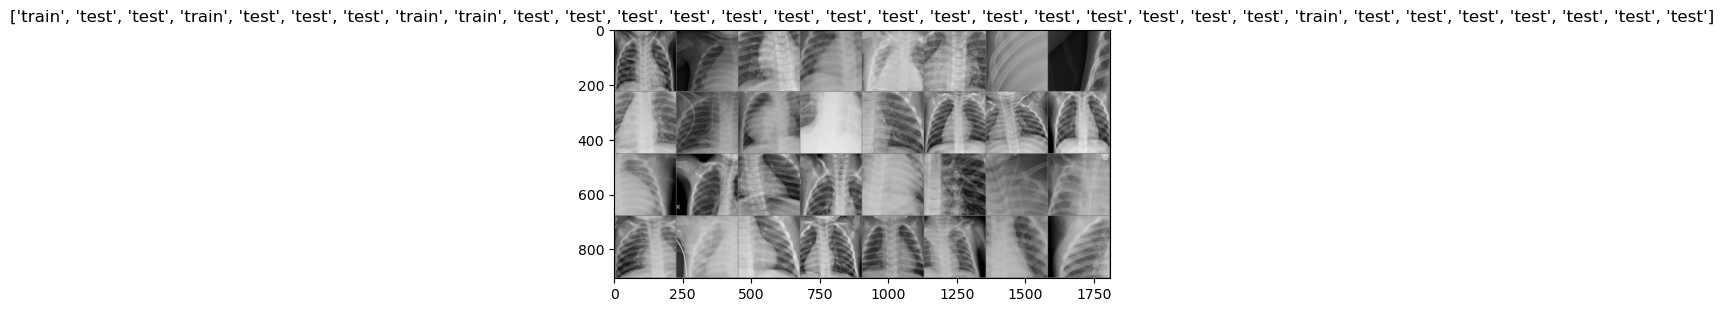

In [28]:
import torchvision


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [29]:
model = models.resnet18(weights=True)

# Geler les paramètres du modèle
for param in model.parameters():
    param.requires_grad = False

# Modifier la dernière couche fully connected pour correspondre au nombre de classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

In [30]:
import copy

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Fonction pour entraîner le modèle
def train_model(model, criterion, optimizer, num_epochs=1):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Chaque époque comporte une phase d'entraînement et une phase de validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Mode entraînement
            else:
                model.eval()   # Mode évaluation

            running_loss = 0.0
            running_corrects = 0

            # Parcourir les données
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Réinitialiser les gradients
                optimizer.zero_grad()

                # Propagation avant
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Propagation arrière + optimisation si en mode entraînement
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistiques
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Profonde copie du meilleur modèle
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # Charger les meilleurs poids du modèle
    model.load_state_dict(best_model_wts)
    return model

model = train_model(model, criterion, optimizer, num_epochs=1)

Epoch 0/0
----------
train Loss: 0.3865 Acc: 0.8852
val Loss: 0.3602 Acc: 0.8907

Best val Acc: 0.890710


In [31]:
# Évaluer le modèle sur les données de test
model.eval()
running_corrects = 0

for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    running_corrects += torch.sum(preds == labels.data)

test_acc = running_corrects.double() / dataset_sizes['test']
print('Test Accuracy: {:.4f}'.format(test_acc))

Test Accuracy: 0.8907


In [32]:
# Sauvegarder le modèle
torch.save(model.state_dict(), 'model.pth')

# Charger le modèle
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model.load_state_dict(torch.load('model.pth'))
model = model.to(device)